In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%データセットのダウンロード
!pip install gdown

import gdown
file_id = "1-EyM2kIj24P6DtT-swZP8DLyBAPU1PkU"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.zip"
gdown.download(url, output, quiet=False)
!unzip "dataset.zip"


'%データセットのダウンロード\n!pip install gdown\n\nimport gdown\nfile_id = "1-EyM2kIj24P6DtT-swZP8DLyBAPU1PkU"\nurl = f"https://drive.google.com/uc?id={file_id}"\noutput = "dataset.zip"\ngdown.download(url, output, quiet=False)\n!unzip "dataset.zip"\n'

In [ ]:
#import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
print(torch.__version__)
torch.manual_seed(0)


1.8.1+cu101


In [ ]:

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
LReLU_alpha = 0.2

#https://github.com/yuuho/stylegans-pytorch/blob/master/network/stylegan2.py　を参考に
from torch.nn import functional as F
class equalized_linear(nn.Module):
    def __init__(self,in_features,out_features,lr = 1):
        super(equalized_linear, self).__init__()
        
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        torch.nn.init.normal_(self.weight.data, mean=0.0, std=1.0/lr)
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.weight_scaler = lr / (in_features ** 0.5)
        self.lr = lr

    def forward(self,x):  
        return F.linear(x, self.weight * self.weight_scaler, self.bias * self.lr)
        

class modulated_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros',mod = True):
        super(modulated_conv2d, self).__init__()
        self.padding, self.stride = padding, stride

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        torch.nn.init.normal_(self.weight.data, mean=0.0, std=1.0)
        #self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(1,out_channels,1,1))
        self.weight_scaler = 1 / (in_channels * kernel_size*kernel_size)**0.5
        self.mod = mod
        '''
        if not mod:
            torch.nn.init.normal_(self.weight.data, mean=0.0, std=1.0 *  self.weight_scaler)
        else:
            torch.nn.init.normal_(self.weight.data, mean=0.0, std=1.0)
        '''

    def forward(self,x,style=None,shape = None,web = False,style_2 = None):
        oC, iC, kH, kW = self.weight.shape
        if shape is None:
            N, iC, H, W = x.shape
        else:
            N, iC, H, W = shape
        
        if not self.mod:
            weight = self.weight.view(1,oC,iC,kH,kW) * self.weight_scaler
            if not web:
                weight = weight.repeat(N,1,1,1,1)

            x = F.conv2d(x.view(1,N*iC,H,W), weight.view(N*oC,iC,kH,kW),
                    padding=self.padding, stride=self.stride, groups=N)
            if web:
                return x.view(N,oC,H,W) + self.bias
            
            return x.view(N,oC,x.shape[2],x.shape[3]) + self.bias

        if web:
            modulated_weight = self.weight.view(1,oC,iC,kH,kW) * self.weight_scaler 
            #modulated_weight = modulated_weight.repeat(N,1,1,1,1)
            x = x * style.view(N,iC,1,1)
            x = F.conv2d(x.view(1,N*iC,H,W), modulated_weight.view(N*oC,iC,kH,kW),
                    padding=self.padding, stride=self.stride, groups=N).view(N,oC,H,W)
            modulated_weight = modulated_weight * style_2.view(N,1,iC,1,1)
            demod_norm = 1 / torch.sqrt((modulated_weight * modulated_weight).sum([2,3,4])  + 1e-8)
            out = x * demod_norm.view(N, oC, 1, 1) + self.bias   

        else:
            modulated_weight = self.weight_scaler*self.weight.view(1,oC,iC,kH,kW) * style.view(N,1,iC,1,1) 

            demod_norm = 1 / torch.sqrt((modulated_weight * modulated_weight).sum([2,3,4]) + 1e-8) # (N, oC)
            demodulated_weight = modulated_weight * demod_norm.view(N, oC, 1, 1, 1) 
            #demodulated_weight = modulated_weight
            out = F.conv2d(x.view(1,N*iC,H,W), demodulated_weight.view(N*oC,iC,kH,kW),
                    padding=self.padding, stride=self.stride, groups=N).view(N,oC,H,W) + self.bias
            
        return out

def alternative_Upsample(image,input_size):
    batches, channels, h, w = input_size

    x = image.view(batches, channels, h * w, 1)
    x = torch.cat((x,x),3)
    x = x.view(batches, channels, h, w * 2)
    x = torch.cat((x,x),3)
    x = x.view(batches, channels, h * 2, w * 2)
    return x
# Define model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        dimensions = [256,256,256,256,128,128,128,64,64,64,32,32]
        self.learning_const = torch.randn((1,dimensions[1],4,4),requires_grad=True, device = device)
        self.mapping_network = self.generate_mapping_network(dimensions[0])

        self.affine_4_0 = self.make_latent_to_style(dimensions[0],dimensions[1])
        self.block_4_0 = self.generate_block(4,dimensions[1],dimensions[2])
        self.noise_4_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_4_1 = self.make_latent_to_style(dimensions[0],dimensions[2])
        self.block_4_1 = self.generate_block(4,dimensions[2],dimensions[3])
        self.noise_4_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_4 = modulated_conv2d(dimensions[3],3,kernel_size=1,stride=1,padding=0,mod = False)

        self.affine_8_0 = self.make_latent_to_style(dimensions[0],dimensions[3])
        self.block_8_0 = self.generate_block(8,dimensions[3],dimensions[4],True)
        self.noise_8_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_8_1 = self.make_latent_to_style(dimensions[0],dimensions[4])
        self.block_8_1 = self.generate_block(8,dimensions[4],dimensions[5])
        self.noise_8_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_8 = modulated_conv2d(dimensions[5],3,kernel_size=1,stride=1,padding=0,mod = False)

        self.affine_16_0 = self.make_latent_to_style(dimensions[0],dimensions[5])
        self.block_16_0 = self.generate_block(16,dimensions[5],dimensions[6],True)
        self.noise_16_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_16_1 = self.make_latent_to_style(dimensions[0],dimensions[6])
        self.block_16_1 = self.generate_block(16,dimensions[6],dimensions[7])
        self.noise_16_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_16 = modulated_conv2d(dimensions[7],3,kernel_size=1,stride=1,padding=0,mod = False)

        self.affine_32_0 = self.make_latent_to_style(dimensions[0],dimensions[7])
        self.block_32_0 = self.generate_block(32,dimensions[7],dimensions[8],True)
        self.noise_32_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_32_1 = self.make_latent_to_style(dimensions[0],dimensions[8])
        self.block_32_1 = self.generate_block(32,dimensions[8],dimensions[9])
        self.noise_32_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_32 = modulated_conv2d(dimensions[9],3,kernel_size=1,stride=1,padding=0,mod = False)

        self.affine_64_0 = self.make_latent_to_style(dimensions[0],dimensions[9])
        self.block_64_0 = self.generate_block(64,dimensions[9],dimensions[10],True)
        self.noise_64_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_64_1 = self.make_latent_to_style(dimensions[0],dimensions[10])
        self.block_64_1 = self.generate_block(64,dimensions[10],dimensions[11])
        self.noise_64_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_64 = modulated_conv2d(dimensions[11],3,kernel_size=1,stride=1,padding=0,mod = False)
        for i in range(5):          
            for j in range(2):
                nn.init.constant_(getattr(self, 'affine_{0}_{1}'.format(2 ** (i + 2),j)).bias, 1.0)         

    def generate_mapping_network(self,dimension = 512,number_of_layer = 1):
       mapping_network = nn.Sequential()
       for i in range(number_of_layer):
           mapping_network.add_module('mapping_fc{0}'.format(i), equalized_linear(dimension,dimension,lr = 0.01))
           mapping_network.add_module('mapping_lrelu{0}'.format(i), nn.LeakyReLU(LReLU_alpha))
       return mapping_network

    def generate_block(self,image_size = 4,in_dimension = 512, out_dimension = 512,upscaling = False):
        return modulated_conv2d(in_dimension,out_dimension,kernel_size=3,stride=1,padding=1)
        #return torch.nn.Conv2d(in_dimension,out_dimension,kernel_size=3,stride=1,padding=1)
    def make_latent_to_style(self,latent_dimension = 512, target_dimension = 512):
        return equalized_linear(latent_dimension, target_dimension)

    def forward(self, z, stage = 1 ,alpha = 0, batches = 1,web = False):
        style = self.mapping_network(z)
        if web:
            #mapping_network_2 = self.mapping_network_2(z)
            style_2 = self.mapping_network(z)
        x = self.learning_const.repeat(int(batches),1,1,1)
        for i in range(stage):
            if i != 0:
                if web:
                    x = alternative_Upsample(x,(1,-1,2 ** (i + 1),2 ** (i + 1)))
                else:
                    x = F.interpolate(x,scale_factor=2, mode='nearest')
            for j in range(2):
                #if not (i == 0 and j == 0):
                affined_style = getattr(self, 'affine_{0}_{1}'.format(2 ** (i + 2),j))(style)

                if web:
                    affined_style_2 = getattr(self, 'affine_{0}_{1}'.format(2 ** (i + 2),j))(style_2)
                    x = getattr(self, 'block_{0}_{1}'.format(2 ** (i + 2),j))(x,affined_style,shape = (1,-1,2 ** (i + 2),2 ** (i + 2)),style_2 = affined_style_2,web = True)
                else:
                    x = getattr(self, 'block_{0}_{1}'.format(2 ** (i + 2),j))(x,affined_style,web = False)
                x = F.leaky_relu(x,LReLU_alpha)
                    #x = x + torch.randn(x.shape, device = device) *  getattr(self, 'noise_{0}_{1}'.format(2 ** (i + 2),j))

            if i == 0:
                if web:
                    x_out = getattr(self, 'to_rgb_{0}'.format(2 ** (i + 2)))(x,shape = (1,-1,int(2 ** (i + 2)),int(2 ** (i + 2))),web = True)
                else:
                    x_out = getattr(self, 'to_rgb_{0}'.format(2 ** (i + 2)))(x,web = False) 
            else:
                if web:
                    x_out_2 = getattr(self, 'to_rgb_{0}'.format(2 ** (i + 2)))(x,shape = (1,-1,int(2 ** (i + 2)),int(2 ** (i + 2))),web = True)
                else:
                    x_out_2 = getattr(self, 'to_rgb_{0}'.format(2 ** (i + 2)))(x,web = False) 
                
                if web:
                    x_out = alternative_Upsample(x_out,(1,-1,2 ** (i + 1),2 ** (i + 1))) + x_out_2
                else:
                    x_out = F.interpolate(x_out,scale_factor=2, mode='nearest') + x_out_2
                    
        '''
        if web:
            x_out = getattr(self, 'to_rgb_{0}'.format(2 ** (stage + 1)))(x,shape = (1,-1,int(2 ** (stage + 1)),int(2 ** (stage + 1))),web = True)
        else:
            x_out = getattr(self, 'to_rgb_{0}'.format(2 ** (stage + 1)))(x,web = False)
        #x_out = F.tanh(x_out)

        if alpha != 0:
            if web:
                x = alternative_Upsample(x,(1,-1,2 ** (stage + 1),2 ** (stage + 1)))
            else:
                x = torch.nn.functional.interpolate(x,scale_factor=2, mode='nearest')
            for j in range(2):
                affined_style = getattr(self, 'affine_{0}_{1}'.format(2 ** (stage + 2),j))(style)
                if web:
                    affined_style_2 = getattr(self, 'affine_{0}_{1}'.format(2 ** (stage + 2),j))(style_2)
                if web:
                    x = getattr(self, 'block_{0}_{1}'.format(2 ** (stage + 2),j))(x,affined_style,shape = (1,-1,2 ** (i + 2),2 ** (i + 2)),style_2 = affined_style_2,web = True)
                else:
                    x = getattr(self, 'block_{0}_{1}'.format(2 ** (stage + 2),j))(x,affined_style,web =False)
                
                x = F.leaky_relu(x,LReLU_alpha)
                #x = x + torch.randn(x.shape, device = device) * getattr(self, 'noise_{0}_{1}'.format(2 ** (i + 2),j))
            x = getattr(self, 'to_rgb_{0}'.format(2 ** (stage + 2)))(x)
            #x = F.tanh(x)
            if web:
                x_out = alpha * x + alternative_Upsample(x_out,(1,-1,2 ** (stage + 1),2 ** (stage + 1))) * (1 - alpha)
            else:
                x_out = alpha * x + torch.nn.functional.interpolate(x_out,scale_factor=2, mode='nearest') * (1 - alpha)
        '''  
        return x_out

Using cuda device


In [ ]:
# Define model
from torch.autograd import Variable
from torch import autograd
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        dimensions = [256,256,256,128,128,128,64,64,64,32,32,32]

        self.from_rgb_4 = modulated_conv2d(3,dimensions[2],kernel_size=1,stride=1,padding=0,mod = False)
        self.block_4_0 = self.generate_block(4,dimensions[2],dimensions[1])
        self.block_4_1 = self.generate_block(4,dimensions[1],dimensions[0])

        self.from_rgb_8 = modulated_conv2d(3,dimensions[4],kernel_size=1,stride=1,padding=0,mod = False)
        self.block_8_0 = self.generate_block(8,dimensions[4],dimensions[3])
        self.block_8_1 = self.generate_block(8,dimensions[3],dimensions[2])

        self.from_rgb_16 = modulated_conv2d(3,dimensions[6],kernel_size=1,stride=1,padding=0,mod = False)
        self.block_16_0 = self.generate_block(16,dimensions[6],dimensions[5])
        self.block_16_1 = self.generate_block(16,dimensions[5],dimensions[4])

        self.from_rgb_32 = modulated_conv2d(3,dimensions[8],kernel_size=1,stride=1,padding=0,mod = False)
        self.block_32_0 = self.generate_block(32,dimensions[8],dimensions[7])
        self.block_32_1 = self.generate_block(32,dimensions[7],dimensions[6])

        self.from_rgb_64 = modulated_conv2d(3,dimensions[10],kernel_size=1,stride=1,padding=0,mod = False)
        self.block_64_0 = self.generate_block(64,dimensions[10],dimensions[9])
        self.block_64_1 = self.generate_block(64,dimensions[9],dimensions[8])

        self.final_conv_1 = modulated_conv2d(dimensions[0] + 1,dimensions[0],kernel_size=3,stride=1,padding=1,mod = False)
        self.final_conv_2 = modulated_conv2d(dimensions[0],dimensions[0],kernel_size=4,stride=1,padding=0,mod = False)
        self.linear = equalized_linear(dimensions[0],1)
        #self.linear = nn.Linear(dimensions[0],1)#equalized_linear(dimensions[0],1)
        #for i in range(5):
        #    nn.init.normal_(getattr(self, 'from_rgb_{0}'.format(2 ** (i + 2))).weight, 0.0, 1.0 / getattr(self, 'from_rgb_{0}'.format(2 ** (i + 2))).weight.shape[1] ** 0.5)
        #    nn.init.constant_(getattr(self, 'from_rgb_{0}'.format(2 ** (i + 2))).bias, 0.0)

    def generate_block(self,image_size = 4,in_dimension = 512, out_dimension = 512):
        block = nn.Sequential()

        block.add_module('Conv', modulated_conv2d(in_dimension,out_dimension,kernel_size=3,stride=1,padding=1,mod = False))
        #block.add_module('Conv', nn.Conv2d(in_dimension,out_dimension,kernel_size=3,stride=1,padding=1))
        block.add_module('relu', nn.LeakyReLU(LReLU_alpha))
        #nn.init.normal_(block.Conv.weight, 0.0, 1.0 / (in_dimension * 3*3)**0.5)
        #nn.init.constant_(block.Conv.bias, 0)

        return block
    #https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py を改変
    def calculate_gradient_penalty(self, real_images, fake_images,batch_size,stage,alpha):
        #eta = torch.FloatTensor(batch_size,1,1,1).uniform_(0,1).to(device)
        #eta = eta.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3))

        interpolated = real_images#eta * real_images + ((1 - eta) * fake_images)

        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)
        # calculate probability of interpolated examples
        prob_interpolated = self(interpolated,stage,alpha,batch_size)
        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                              grad_outputs=torch.ones(
                                  prob_interpolated.size()).to(device),
                              create_graph=True, retain_graph=True)[0]
                              
        #grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        grad_penalty = (gradients ** 2).sum() #(gradients.norm(2, dim=1) ** 2).mean()
        return grad_penalty
    
    def forward(self, image, stage = 1 ,alpha = 0, batches = 1):
        '''
        if alpha != 0:
            x = getattr(self, 'from_rgb_{0}'.format(2 ** (stage + 2)))(image)
            x = nn.LeakyReLU(LReLU_alpha)(x)
            for j in range(2):
                x = getattr(self, 'block_{0}_{1}'.format(2 ** (stage + 2),j))(x)
            x = torch.nn.functional.interpolate(x,scale_factor=0.5, mode='nearest')
            x2 = getattr(self, 'from_rgb_{0}'.format(2 ** (stage + 1)))(torch.nn.functional.interpolate(image,scale_factor=0.5, mode='nearest'))
            x2 = nn.LeakyReLU(LReLU_alpha)(x2)
            x = x * alpha + x2 * (1 - alpha)
        else:
            x = getattr(self, 'from_rgb_{0}'.format(2 ** (stage + 1)))(image)
            x = nn.LeakyReLU(LReLU_alpha)(x)
        '''

        for i in range(stage):
            image = F.interpolate(image,size=int(2 ** (stage + 1 - i)), mode='nearest')
            if i == 0:
                x =  F.leaky_relu(getattr(self, 'from_rgb_{0}'.format(2 ** (stage + 1 - i)))(image),LReLU_alpha)
            else:
                x = x + F.leaky_relu(getattr(self, 'from_rgb_{0}'.format(2 ** (stage + 1 - i)))(image),LReLU_alpha)
            for j in range(2):
                #if not (i == stage - 1 and j == 1):
                x = getattr(self, 'block_{0}_{1}'.format(2 ** (stage + 1 - i),j))(x)
            if i != stage - 1:
                x = torch.nn.functional.interpolate(x,scale_factor=0.5, mode='nearest')
        
        minibatch_std = torch.std(x , dim=(0,1))
        x = torch.cat((x,minibatch_std.broadcast_to(batches,1,4,4)),dim = 1)
        x = self.final_conv_1(x)
        x = F.leaky_relu(x,LReLU_alpha)
        x = self.final_conv_2(x)
        x = F.leaky_relu(x,LReLU_alpha)
        x = nn.Flatten()(x)
        return  self.linear(x)

In [ ]:
class trainer():
    def __init__(self,learning_rate = 0.0001):
        self.MAX_STAGE = 4
        self.BATCH_SIZE = 128
        self.n_critic = 1
        self.gp_lamda = 10
        self.g = Generator().to(device)
        self.d = Discriminator().to(device)
        self.G_optimizer = torch.optim.Adam(self.g.parameters(), lr=learning_rate)
        self.D_optimizer = torch.optim.Adam(self.d.parameters(), lr=learning_rate)
        self.NUM_EPOCH_NO_ALPHA = 10
        self.NUM_EPOCH_WITH_ALPHA = 10
        self.z_dimension = 256
        self.alpha = 0
        self.stage = (self.MAX_STAGE - 1) * 2 +1e-8
    def train(self):
        MAX_STAGE = self.MAX_STAGE
        BATCH_SIZE = self.BATCH_SIZE
        n_critic = self.n_critic
        gp_lamda = self.gp_lamda
        g = self.g
        d = self.d
        G_optimizer = self.G_optimizer
        D_optimizer = self.D_optimizer
        NUM_EPOCH_NO_ALPHA = self.NUM_EPOCH_NO_ALPHA
        NUM_EPOCH_WITH_ALPHA = self.NUM_EPOCH_WITH_ALPHA
        z_dimension = self.z_dimension
        training_data = datasets.CIFAR10(
            root="data",
            train=True,
            download=True,
            transform=ToTensor(),
        )
        train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        tick = 0
        while True:
            #for epoch in range(NUM_EPOCH_NO_ALPHA + NUM_EPOCH_WITH_ALPHA):
            for X, _ in train_dataloader:
                X = X * 2 - 1
                    
                alpha = 0
                if int(self.stage) % 2 == 1:
                    self.stage += 1 / (len(train_dataloader) * NUM_EPOCH_WITH_ALPHA) 
                elif math.ceil(self.stage / 2) < self.MAX_STAGE:
                     self.stage += 1 / (len(train_dataloader) * NUM_EPOCH_NO_ALPHA)
                stage = math.ceil(self.stage / 2)    
                if int(self.stage) % 2 == 1:
                    alpha = self.stage - int(self.stage)
                    
                for _ in range(n_critic):                      
                    z = torch.randn((BATCH_SIZE,z_dimension),device = device)
                    generated = g(z, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                    X = X.to(device)
                    X = torch.nn.functional.interpolate(X,size=generated.size(2), mode='nearest')
                    if alpha != 0:
                        X_2 = F.interpolate(F.interpolate(X,size=int(generated.size(2) / 2), mode='nearest'),size=generated.size(2), mode='nearest')
                        X = X * alpha + X_2 * (1 - alpha)
               
                    y_real = d(X, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                    y_fake = d(generated, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                    #d_loss = torch.mean(y_fake) - torch.mean(y_real)
                    d_loss = torch.mean(F.softplus(y_fake) + F.softplus(-y_real))#- torch.mean(torch.log(torch.sigmoid(y_real))) - torch.mean(torch.log(1 - torch.sigmoid(y_fake)))#
                    d_loss = d_loss + d.calculate_gradient_penalty(X,generated,BATCH_SIZE,stage,alpha) * gp_lamda
                    #Wasserstein_loss =  (torch.mean(y_fake) - torch.mean(y_real)).data
                    Wasserstein_loss =  torch.mean(F.softplus(y_fake) + F.softplus(-y_real)).data

                    D_optimizer.zero_grad()
                    d_loss.backward()
                    D_optimizer.step()

                g_loss = 'undefined'
                if True:#Wasserstein_loss <= 0:
                    z = torch.randn((BATCH_SIZE,z_dimension),device = device)
                    generated = g(z, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                    y_fake = d(generated, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                    #g_loss = -torch.mean(y_fake)
                    g_loss = torch.mean(F.softplus(-y_fake)) #torch.mean(torch.log(1 - torch.sigmoid(y_fake)))#
                    G_optimizer.zero_grad()
                    g_loss.backward()
                    G_optimizer.step()

                    

                if tick % 100 == 0:
                    print('progress:{},stage:{},alpha{},g_loss:{}, d_loss:{}, Pure discriminator Loss:{}'.format(self.stage,stage,alpha,g_loss,d_loss,Wasserstein_loss))
                    generated = g(z, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                    show_image(generated)
                    show_image(X)
                    torch.save(self, '/content/drive/MyDrive/StyleGAN2/model.pth')
                tick += 1

In [ ]:
#util for training
from IPython.display import Image,display_png
from PIL import Image
import math

def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((width*cols, height*rows,3),
                              dtype=generated_images.dtype)
    #coreturn combined_image

    for index, image in enumerate(generated_images):
        i = index % cols
        j = int(index/cols)
        combined_image[width*i:width*(i+1), height*j:height*(j+1),0:3] = image[:,:,0:3 ]
    return combined_image

def show_image(result):
    generated_image = result.to('cpu').detach().numpy().copy()
    generated_image = generated_image * 127.5 + 127.5
    generated_image = np.where(generated_image < 0, 0, generated_image)
    generated_image = np.where(generated_image > 255, 255, generated_image)
    generated_image=np.transpose(generated_image, (0, 2, 3, 1))
    generated_image = combine_images(generated_image)
    generated_image = generated_image.astype(np.uint8)
    image = Image.fromarray(generated_image)
    display_png(image)

load failed
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


progress:6.000128040973111,stage:4,alpha0,g_loss:0.7081687450408936, d_loss:15.323752403259277, Pure discriminator Loss:1.380681037902832


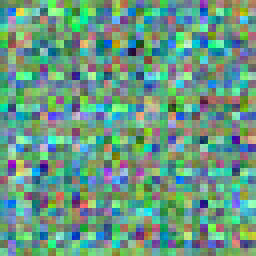

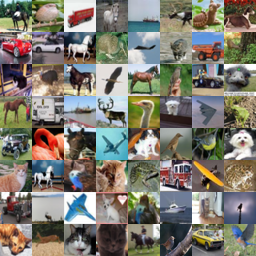

progress:6.000128040973111,stage:4,alpha0,g_loss:0.7456248998641968, d_loss:1.918696641921997, Pure discriminator Loss:1.3001561164855957


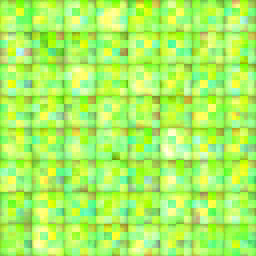

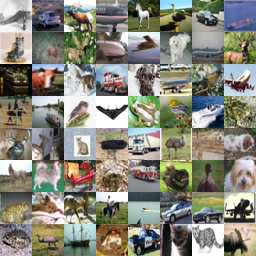

progress:6.000128040973111,stage:4,alpha0,g_loss:0.7176351547241211, d_loss:1.54258394241333, Pure discriminator Loss:1.3703067302703857


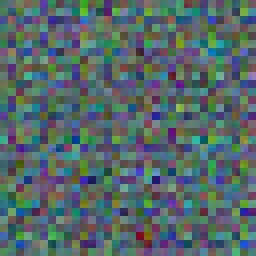

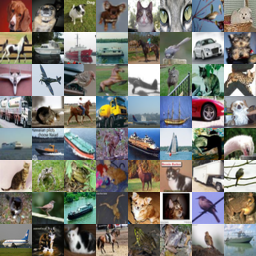

progress:6.000128040973111,stage:4,alpha0,g_loss:0.697221040725708, d_loss:1.4483646154403687, Pure discriminator Loss:1.3435640335083008


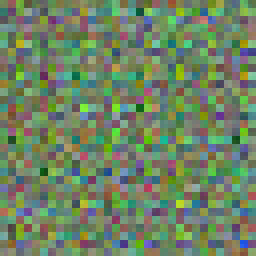

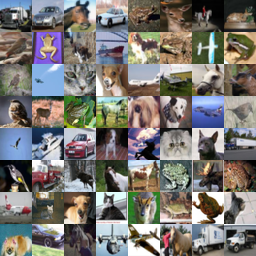

In [ ]:
try:
    train = torch.load('/content/drive/MyDrive/StyleGAN2/model.pth')
    print('loaded')
except:
    train = trainer(0.0001)
    print('load failed')

train.BATCH_SIZE = 64
train.train()

In [ ]:
#make ONNX model
try:
    train = torch.load('/content/drive/MyDrive/StyleGAN2/model.pth')
except:
    train = trainer()
    print('load failed')

dummy_input = torch.randn(1, train.z_dimension, device=device)
train.g.learning_const.requires_grad = False
for i in range(5):  
    for j in range(2):
        getattr(train.g, 'noise_{0}_{1}'.format(2 ** (i + 2),j)).requires_grad = False
        getattr(train.g, 'noise_{0}_{1}'.format(2 ** (i + 2),j)).requires_grad = False
stage = torch.tensor(4, dtype=torch.int)
alpha = torch.tensor(0, dtype=torch.int)
batches = torch.tensor(1, dtype=torch.int)
web = torch.tensor(True, dtype=torch.bool)
torch.onnx.export(train.g, (dummy_input,stage,alpha,batches,web), 'generator.onnx', opset_version= 9)

from google.colab import files
files.download('generator.onnx')


In [ ]:

#testing
train = torch.load('/content/drive/MyDrive/StyleGAN2/model.pth')
#train = trainer()
z = torch.zeros(1, train.z_dimension, device=device)
generated= train.g(z,stage = 1,web=True)
#show_image(generated)
print(generated)